In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import mpl_lego as mplego
import pandas as pd

from hatespeech.keys import (items,
                             race_to_col,
                             annotator_race_to_col,
                             annotator_gender,
                             annotator_educ,
                             annotator_income,
                             annotator_religion_to_col,
                             annotator_sexual_orientation_to_col,
                             annotator_ideology)
from hatespeech import utils
from IPython.display import Markdown
from scipy.stats import f_oneway, kruskal

%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
mplego.style.use_latex_style()

In [4]:
exp = "05"
base_path = os.path.join(os.environ['HOME'], 'projects/hatespeech-2021-fairml')
data_path = os.path.join(os.environ['HOME'], 'data/hatespeech/clean_qualtrics_irt_rollout.feather')
rater_quality_path = "~/data/hatespeech/rater_quality_check.csv"
results_path = os.path.join(base_path, f'scaling/experiments/exp{exp}')

In [5]:
data = pd.read_feather(data_path).rename(columns={'violence_phys': 'violence'})
# Remove all rows in which some item is missing
data = utils.filter_missing_items(data)
# Remove all rows in which the rater is not up to sufficient quality
rater_quality = pd.read_csv(rater_quality_path)
data = utils.filter_annotator_quality(data, rater_quality)
# Recode item responses
data = utils.recode_responses(
    data,
    insult={1: 0, 2: 1, 3: 2, 4: 3},
    humiliate={1: 0, 2: 0, 3: 1, 4: 2},
    status={1: 0, 2: 0, 3: 1, 4: 1},
    dehumanize={1: 0, 2: 0, 3: 1, 4: 1},
    violence={1: 0, 2: 0, 3: 1, 4: 1},
    genocide={1: 0, 2: 0, 3: 1, 4: 1},
    attack_defend={1: 0, 2: 1, 3: 2, 4: 3},
    hatespeech={1: 0, 2: 1})
# Only get comments targeting black / white people
data = utils.filter_comments_targeting_bw(data, threshold=0.5)
data = data[(data[race_to_col['black']] == 1)
            | (data[race_to_col['white']] == 1)]


In [6]:
out_path = os.path.join(results_path, f"exp05_out.txt")

In [7]:
with open(out_path) as f:
    lines = f.readlines()

In [9]:
bias_lines = lines[19905:33647]

In [10]:
bias_cut = bias_lines[4:-7]

In [11]:
n_samples = len(bias_cut)
observed = np.zeros(n_samples)
expected = np.zeros(n_samples)
bias_size = np.zeros(n_samples)
t_stats = np.zeros(n_samples)
p_vals = np.zeros(n_samples)
labeler_id = np.zeros(n_samples)
measure = np.zeros(n_samples)
race = np.zeros(n_samples)

for idx, line in enumerate(bias_cut):
    processed = line.replace('|', ' ').replace('>', ' ').replace('<', ' ').split()
    observed[idx] = float(processed[0])
    expected[idx] = float(processed[1])
    bias_size[idx] = float(processed[4])
    t_stats[idx] = float(processed[6])
    p_vals[idx] = float(processed[8])
    labeler_id[idx] = int(processed[13])
    measure = float(processed[14])
    if processed[16] == 'white':
        race[idx] = 0
    elif processed[16] == 'black':
        race[idx] = 1

In [13]:
df = pd.DataFrame({
    'observed': observed,
    'expected': expected,
    'bias': bias_size,
    't_statistics': t_stats,
    'p_values': p_vals,
    'labeler_id': labeler_id,
    'measure': measure,
    'race': race}).astype({'labeler_id': int})

In [14]:
df['annotator_race'] = 0

In [15]:
subview = data[data['labeler_id'].isin(df['labeler_id'])].drop_duplicates('labeler_id')

In [16]:
df.loc[df['labeler_id'].isin(subview[subview[annotator_race_to_col['black']] == 1]['labeler_id']), 'annotator_race'] = 1

In [17]:
# df.to_csv('interaction_term.csv')

In [17]:
df['bias']

0        0.00
1       -0.03
2       -0.36
3        0.41
4        0.00
         ... 
13726    0.00
13727   -0.10
13728    0.16
13729    0.00
13730    0.00
Name: bias, Length: 13731, dtype: float64

In [36]:
data[data['labeler_id'] == 3299][['predict_text'] + items].loc[3206]

predict_text     I dated a guy for like 2 weeks cuz I'm clinica...
sentiment                                                      2.0
respect                                                        2.0
insult                                                         2.0
humiliate                                                      1.0
status                                                         2.0
dehumanize                                                     0.0
violence                                                       0.0
genocide                                                       0.0
attack_defend                                                  2.0
hatespeech                                                     0.0
Name: 3206, dtype: object

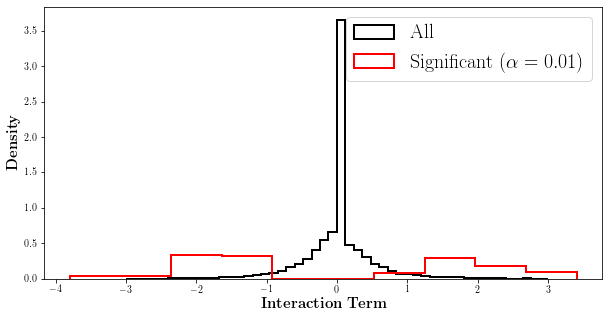

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(df['bias'], bins=np.linspace(-3, 3, 51), histtype='step', color='black', lw=2, density=True, label='All')
ax.hist(df[df['p_values'] < 0.01]['bias'], color='red', histtype='step', density=True, lw=2, label=r'Significant ($\alpha=0.01$)')
ax.set_xlabel(r'\textbf{Interaction Term}', fontsize=15)
ax.set_ylabel(r'\textbf{Density}', fontsize=15)
ax.legend(prop={'size': 20})
#plt.savefig('interaction_terms.png', dpi=300)

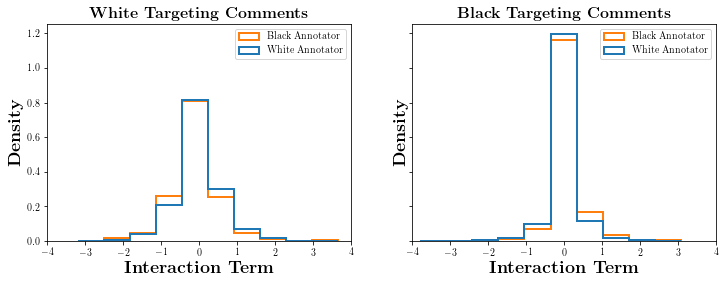

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].hist(
    [df[(df['annotator_race'] == 0) & (df['race'] == 0)]['bias'],
     df[(df['annotator_race'] == 1) & (df['race'] == 0)]['bias']],
    histtype='step',
    density=True,
    lw=2,
    label=['White Annotator', 'Black Annotator']
)

axes[1].hist(
    [df[(df['annotator_race'] == 0) & (df['race'] == 1)]['bias'],
     df[(df['annotator_race'] == 1) & (df['race'] == 1)]['bias']],
    histtype='step',
    density=True,
    lw=2,
    label=['White Annotator', 'Black Annotator']
)

axes[0].set_title(r'\textbf{White Targeting Comments}', fontsize=16)
axes[1].set_title(r'\textbf{Black Targeting Comments}', fontsize=16)

for ax in axes:
    ax.legend()
    ax.set_xlim([-4, 4])
    ax.set_xlabel(r'\textbf{Interaction Term}', fontsize=18)
    ax.set_ylabel(r'\textbf{Density}', fontsize=18)

#plt.savefig('interaction_terms_all_annotators.png', dpi=300)

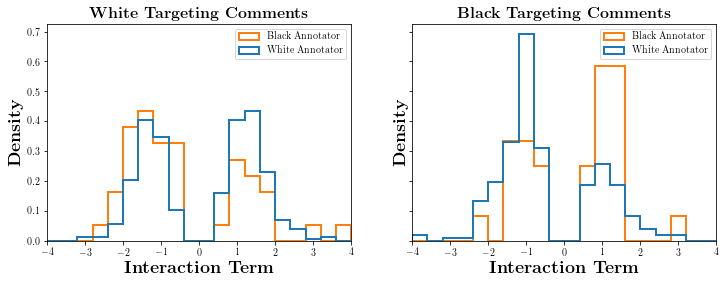

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].hist(
    [df[(df['annotator_race'] == 0) & (df['race'] == 0) & (df['p_values'] < 0.1)]['bias'],
     df[(df['annotator_race'] == 1) & (df['race'] == 0) & (df['p_values'] < 0.1)]['bias']],
    histtype='step',
    density=True,
    bins=np.linspace(-4, 4, 21),
    lw=2,
    label=['White Annotator', 'Black Annotator']
)

axes[1].hist(
    [df[(df['annotator_race'] == 0) & (df['race'] == 1) & (df['p_values'] < 0.1)]['bias'],
     df[(df['annotator_race'] == 1) & (df['race'] == 1) & (df['p_values'] < 0.1)]['bias']],
    histtype='step',
    density=True,
    lw=2,
    bins=np.linspace(-4, 4, 21),
    label=['White Annotator', 'Black Annotator']
)

axes[0].set_title(r'\textbf{White Targeting Comments}', fontsize=16)
axes[1].set_title(r'\textbf{Black Targeting Comments}', fontsize=16)

for ax in axes:
    ax.legend(loc='best')
    ax.set_xlim([-4, 4])
    ax.set_xlabel(r'\textbf{Interaction Term}', fontsize=18)
    ax.set_ylabel(r'\textbf{Density}', fontsize=18)
    
#plt.savefig('interaction_terms_significant_annotators.png', dpi=300)

In [22]:
df.sort_values('p_values')

,observed,expected,bias,t_statistics,p_values,labeler_id,measure,race,annotator_race
11467,24.0,36.77,-2.03,-4.99,0.0000,8217,0.87,1.0,0
3817,45.0,32.23,1.73,4.54,0.0001,8217,0.87,0.0,0
3839,4.0,14.61,-2.64,-4.54,0.0002,8261,0.87,0.0,0
2746,26.0,15.32,1.51,4.19,0.0002,6028,0.87,0.0,0
9778,16.0,26.68,-2.11,-4.68,0.0002,6028,0.87,1.0,0
...,...,...,...,...,...,...,...,...,...
9102,15.0,15.00,0.00,0.00,1.0000,5163,0.87,1.0,0
6670,13.0,13.00,0.00,0.00,1.0000,1968,0.87,1.0,0
12204,40.0,40.00,0.00,0.00,1.0000,9183,0.87,1.0,0
6680,17.0,17.00,0.00,0.00,1.0000,1979,0.87,1.0,0


In [27]:
data[data['labeler_id'] == 8217][['predict_text', 'comment_id', 'target_black'] + items]

,predict_text,comment_id,target_black,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech
4628,You guys are really sticking it to White people by leaving them enormous tips and buying them brunch. Keep fighting the good fight.,38505,False,3,3,2,1,1,0,0,0,2,0
7883,"@RicharlisonStan yea your cracker ass isnt allowed to say that to me on God, you will feel the consequences next time whitey",34200,False,4,4,3,1,1,1,1,1,3,1
15557,man i love black chicks,15464,True,0,1,0,0,0,0,0,0,0,0
23799,DO YOU SEE HOW QUICK THE PROSECUTED THAT BLACK COP IN MPLS. MN. FOR KILLING THAT WHITE NIGGA??? GUESS BARR HAND A HAND IN THAT TO HUH. THESE NIGGA'S ARE GONNA GET THEIR DAY!!,20006,True,3,3,0,0,0,0,0,0,0,1
25477,"GEEZ..... I think #NorthKorea may be right. #BarackObama is a monkey! Surely acts like one. URL""",20015,True,4,4,2,1,1,1,0,0,2,1
29880,"It's just really pointless and insulting to people who actually experience racism by implying our society is in need of a reminder that being a white person is okay. Because I doubt one genuine look at history would leave anyone wondering if ""being white"" in the U.S. will be perceived as a problem. The very concept of on a personal level being okay with the fact you were born with the skin color you were born with is of course not racist. But the statement just makes it seem like white people are at risk to become some sort of outcasts.",20052,False,3,4,2,1,0,0,0,0,3,0


In [29]:
data[data['comment_id'] == 34200][['labeler_id'] + items]

,labeler_id,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech
7883,8217,4,4,3,1,1,1,1,1,3,1
7884,3704,4,4,2,0,1,0,0,0,2,1
7885,4660,4,3,2,1,0,0,0,0,1,1
7886,8953,3,3,1,0,0,0,0,0,2,1
